VAMOS A CREAR UN MODELO CON KNN QUE NOS PERMITA DETERMINAR PUNTAJES DE RESTAURANT SEGUN LA UBICACION QUE SE ELIJA. LA IDEA ES QUE DENTRO DE ESOS PUNTOS SE ENCUENTREN CIERTA DENSIDAD DE RESTAURANTES. DENTRO DE ESOS PUNTOS, VAMOS A PODER DETERMINAR EL PORCENTAJE DE EXITO QUE TIENE EL LUGAR, ESTO ES PONDERAR EL PUNTAJE EN BASE A LA INVERSA DE LA DISTANCIA DE SUS VECINOS MAS CERCANOS.

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import folium

In [ ]:
# Apliquemos KNN, que me prediga las puntuaciones del restaurant en el punto elegido, utilizando una ponderacion 
# para que los vecinos mas cercanos tengan mayor peso (podria ser la inversa de la distancia).

1. Ajuste de hiperparámetros
El valor de n_neighbors y otros hiperparámetros como el tipo de distancia pueden impactar el rendimiento del modelo. Usamos la validación cruzada (cross_val_score) y un grid search (GridSearchCV) para encontrar los mejores parámetros.

2. Probar con diferentes métricas de distancia
KNN permite el uso de diferentes métricas de distancia, como la distancia euclidiana, Manhattan o Minkowski. Probaremos con diferentes métricas podría mejorar el rendimiento.


Después de encontrar el mejor modelo a través de GridSearchCV, se imprimen los parámetros del mejor modelo seleccionado:

Número de vecinos (n_neighbors)

Métrica de distancia (metric)

In [5]:
# Cargar los datos desde un archivo CSV
ruta = r'C:\Users\franc\OneDrive\Escritorio\Henry\Cursado Henry\PF\ML_pruebas\df_puntajes_lat_long.csv'
data = pd.read_csv(ruta)

# Seleccionar las columnas necesarias
selected_data = data[['latitud_ciudad', 'longitud_ciudad', 'puntuacion_usuarios']]

# Dividir los datos en características (X) y objetivo (y)
X = selected_data[['latitud_ciudad', 'longitud_ciudad']]
y = selected_data['puntuacion_usuarios']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Configurar el modelo KNN con ponderación por distancia
knn_model = KNeighborsRegressor(weights='distance')

# Ajuste de hiperparámetros usando GridSearchCV
param_grid = {'n_neighbors': [3, 5, 7, 10], 'metric': ['euclidean', 'manhattan', 'minkowski']}
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Mejor modelo
best_knn_model = grid_search.best_estimator_

# Mostrar los parámetros del mejor modelo
print(f"Mejor modelo KNN:")
print(f"- Número de vecinos: {best_knn_model.n_neighbors}")
print(f"- Métrica de distancia: {best_knn_model.metric}")

# Entrenar el mejor modelo
best_knn_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_knn_model.predict(X_test)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred)
#rmse = np.sqrt(mse)
print(f"Error cuadrático medio (MSE): {mse}")
#print(f"RMSE: {rmse}")

# Función para predecir el puntaje basado en latitud y longitud
def predecir_puntaje(latitud, longitud):
    nuevo_dato = pd.DataFrame([[latitud, longitud]], columns=['latitud_ciudad', 'longitud_ciudad'])
    puntaje_predicho = best_knn_model.predict(nuevo_dato)
    return puntaje_predicho[0]

# Ejemplo de uso
latitud_ejemplo = 28.017764
longitud_ejemplo = -82.451033
puntaje = predecir_puntaje(latitud_ejemplo, longitud_ejemplo)
print(f"Puntaje predicho para las coordenadas ({latitud_ejemplo}, {longitud_ejemplo}): {puntaje}")


Mejor modelo KNN:
- Número de vecinos: 10
- Métrica de distancia: manhattan
Error cuadrático medio (MSE): 0.28639582687955495
Puntaje predicho para las coordenadas (28.017764, -82.451033): 4.39791636442712


In [6]:
# Punto 1: coordenadas y puntaje
latitud_ejemplo = 27.8031
longitud_ejemplo = -82.7005

puntaje = predecir_puntaje(latitud_ejemplo, longitud_ejemplo)
print(f"Puntaje predicho para las coordenadas ({latitud_ejemplo}, {longitud_ejemplo}): {puntaje}")

# Crear el mapa centrado en las coordenadas
mapa = folium.Map(location=[latitud_ejemplo, longitud_ejemplo], zoom_start=10)

# Añadir el punto al mapa
tooltip = f"Puntaje: {puntaje}"
folium.Marker(
    [latitud_ejemplo, longitud_ejemplo],
    popup=f"Latitud: {latitud_ejemplo}<br>Longitud: {longitud_ejemplo}<br>Puntaje: {puntaje}",
    tooltip=tooltip,
    icon=folium.Icon(color="red", icon="info-sign")
).add_to(mapa)

# Mostrar el mapa
mapa.save("mapa_prueba.html")
mapa

Puntaje predicho para las coordenadas (27.8031, -82.7005): 4.313954583173372


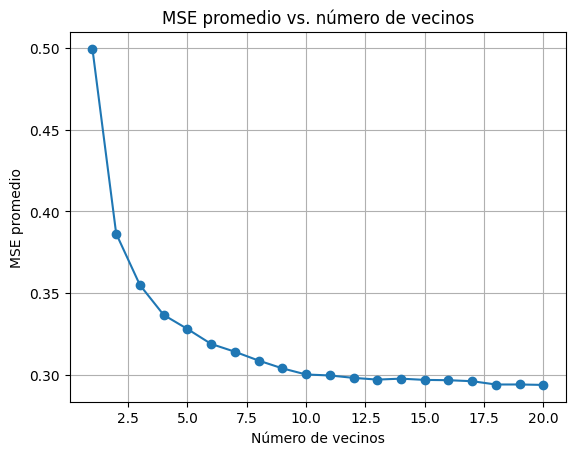

In [12]:
# Visualizacion de la optimizacion de KNN en base al numero de vecinos.

# Cargar los datos desde un archivo CSV
ruta = r'C:\Users\franc\OneDrive\Escritorio\Henry\Cursado Henry\PF\ML_pruebas\df_puntajes_lat_long.csv'
data = pd.read_csv(ruta)

# Seleccionar las columnas necesarias
selected_data = data[['latitud_ciudad', 'longitud_ciudad', 'puntuacion_usuarios']]

# Dividir los datos en características (X) y objetivo (y)
X = selected_data[['latitud_ciudad', 'longitud_ciudad']]
y = selected_data['puntuacion_usuarios']

# Configurar el modelo KNN con ponderación por distancia
knn_model = KNeighborsRegressor(metric='manhattan', weights='distance')

# Probar diferentes valores de n_neighbors
neighbors_range = range(1, 21)  # Probar entre 1 y 20 vecinos
mse_scores = []

# Calcular el MSE para cada valor de n_neighbors utilizando validación cruzada
for n_neighbors in neighbors_range:
    knn_model.n_neighbors = n_neighbors
    mse = -cross_val_score(knn_model, X, y, cv=5, scoring='neg_mean_squared_error').mean()
    mse_scores.append(mse)

# Graficar el MSE promedio vs. número de vecinos
plt.plot(neighbors_range, mse_scores, marker='o')
plt.title('MSE promedio vs. número de vecinos')
plt.xlabel('Número de vecinos')
plt.ylabel('MSE promedio')
plt.grid(True)
plt.show()